In [11]:
"""Imports"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# Supress warning for cleaner output.
# Supressing:
# 	Future deprecation warning: pandas uses M for month frequency gluonts uses ME
# 	Optimal library warning wants us to use ujson instead of standard json
# 	Missing Validation function warning
warnings.filterwarnings("ignore")

from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.torch import DeepAREstimator
from pathlib import Path



## Single File (Not what DeepAR is intended for)

In [12]:
"""Load data from a CSV file into a PandasDataset"""
single_data = pd.read_csv("../Data/SAND706URN.csv",
    index_col=0,
    parse_dates=True,
)
dataset = PandasDataset(single_data, target="SAND706URN")

In [13]:
"""Split data, train and make predictions"""
training_data, test_gen = split(dataset, offset=-12)
test_data = test_gen.generate_instances(prediction_length=12)

# Train the model and make predictions
model = DeepAREstimator(
    prediction_length=12, freq="ME", trainer_kwargs={"max_epochs": 5}
).train(training_data)

forecasts = list(model.predict(test_data.input))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params | Mode  | In sizes                                                   | Out sizes   
--------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 23.3 K | train | [[1, 1], [1, 1], [1, 48, 2], [1, 48], [1, 48], [1, 12, 2]] | [1, 100, 12]
--------------------------------------------------------------------------------------------------------------------------
23.3 K    Trainable params
0         Non-trainable params
23.3 K    Total params
0.093     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 0: |          | 50/? [00:01<00:00, 33.29it/s, v_num=6, train_loss=2.340]

Epoch 0, global step 50: 'train_loss' reached 2.33705 (best 2.33705), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_6/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 31.54it/s, v_num=6, train_loss=1.380]

Epoch 1, global step 100: 'train_loss' reached 1.37615 (best 1.37615), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_6/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 36.29it/s, v_num=6, train_loss=1.210]

Epoch 2, global step 150: 'train_loss' reached 1.20516 (best 1.20516), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_6/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 36.01it/s, v_num=6, train_loss=1.030]

Epoch 3, global step 200: 'train_loss' reached 1.02882 (best 1.02882), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_6/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:01<00:00, 33.73it/s, v_num=6, train_loss=0.962]

Epoch 4, global step 250: 'train_loss' reached 0.96229 (best 0.96229), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_6/checkpoints/epoch=4-step=250.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 50/? [00:01<00:00, 33.54it/s, v_num=6, train_loss=0.962]


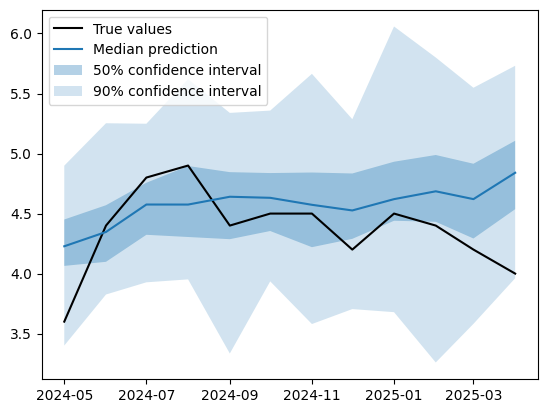

In [18]:
"""Plot predictions"""
plt.plot(single_data["2024-05":], color="black")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values", "Median prediction", "50% confidence interval", "90% confidence interval"], loc="upper left")
plt.show()

## Multiple Timeseries

In [5]:
data_path = Path("../Data/")
dfs = []
for file_name in data_path.iterdir():
    df = pd.read_csv(file_name, parse_dates=True)
    df = df.T
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])
    df["moniker"] = file_name.parts[-1].split(".")[0][:5]
    df = df.reset_index(drop=True)
    dfs.append(df)
    
multi_data = pd.concat(dfs, axis=0).set_index("moniker").reset_index()
multi_data.head()
    

observation_date,moniker,1990-01-01,1990-02-01,1990-03-01,1990-04-01,1990-05-01,1990-06-01,1990-07-01,1990-08-01,1990-09-01,...,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01
0,BAKE5,11.2,12.0,12.6,10.8,9.7,9.8,9.5,9.5,10.0,...,9.3,8.5,7.5,7.6,8.0,8.2,9.0,9.3,9.5,8.9
1,SANF8,3.5,3.3,3.1,3.3,3.3,3.5,4.1,3.9,3.9,...,4.6,4.7,4.2,4.3,4.3,4.0,4.4,4.2,4.1,3.9
2,SANT1,9.1,9.5,9.1,8.9,5.7,5.0,5.4,5.5,5.3,...,5.6,5.5,4.9,5.1,5.7,6.2,7.0,7.3,7.1,6.5
3,SAND7,4.0,3.8,3.7,3.9,4.1,4.5,5.1,5.0,5.4,...,4.8,4.9,4.4,4.5,4.5,4.2,4.5,4.4,4.2,4.0
4,LOSA1,5.2,5.0,4.8,4.9,4.9,4.9,5.5,5.6,5.8,...,6.1,6.2,5.5,5.5,5.5,5.2,5.4,5.4,5.1,4.8


In [6]:
ts_code = multi_data["moniker"].astype("category").cat.codes.values
freq = "ME"
start_train = pd.Timestamp(year=1990, month=1, day=1)
start_test = pd.Timestamp(year=2024, month=5, day=1)

split_point = len(multi_data.iloc[0]) - 12
train_data = multi_data.iloc[:, 1:split_point].values
test_data = multi_data.iloc[:, split_point:].values

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_train,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(train_data,
                             ts_code.reshape(-1, 1))
], freq=freq)

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_test,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(test_data,
                             ts_code.reshape(-1, 1))
], freq=freq)

print(len(train_ds[0]["target"]), "training data time steps") # train = 1990-01-01 - 2024-04-01
print(len(test_ds[0]["target"]), "Test data time steps") # test = 2024-05-01 - 2025-04-01

412 training data time steps
12 Test data time steps


In [7]:
# TODO: Test with different parameters to determine optimal
predictor = DeepAREstimator(freq=freq,
                            context_length=5,
                            prediction_length=12,
                            cardinality=[1],
                            num_layers=50,
                            dropout_rate=0.05,
                            trainer_kwargs={"max_epochs": 10}
                            ).train(training_data=train_ds, num_workers=4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params | Mode  | In sizes                                                   | Out sizes   
--------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 653 K  | train | [[1, 1], [1, 1], [1, 41, 2], [1, 41], [1, 41], [1, 12, 2]] | [1, 100, 12]
--------------------------------------------------------------------------------------------------------------------------
653 K     Trainable params
0         Non-trainable params
653 K     Total params
2.612     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 0: |          | 50/? [00:08<00:00,  5.73it/s, v_num=5, train_loss=2.810]

Epoch 0, global step 50: 'train_loss' reached 2.81161 (best 2.81161), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_5/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:08<00:00,  5.67it/s, v_num=5, train_loss=1.960]

Epoch 1, global step 100: 'train_loss' reached 1.95568 (best 1.95568), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_5/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:06<00:00,  7.33it/s, v_num=5, train_loss=1.800]

Epoch 2, global step 150: 'train_loss' reached 1.80141 (best 1.80141), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_5/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:06<00:00,  7.97it/s, v_num=5, train_loss=1.690]

Epoch 3, global step 200: 'train_loss' reached 1.69039 (best 1.69039), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_5/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:07<00:00,  6.94it/s, v_num=5, train_loss=1.640]

Epoch 4, global step 250: 'train_loss' reached 1.64048 (best 1.64048), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_5/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:06<00:00,  7.24it/s, v_num=5, train_loss=1.670]

Epoch 5, global step 300: 'train_loss' was not in top 1


Epoch 6: |          | 50/? [00:07<00:00,  6.59it/s, v_num=5, train_loss=1.660]

Epoch 6, global step 350: 'train_loss' was not in top 1


Epoch 7: |          | 50/? [00:07<00:00,  6.59it/s, v_num=5, train_loss=1.640]

Epoch 7, global step 400: 'train_loss' reached 1.63511 (best 1.63511), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_5/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:08<00:00,  6.25it/s, v_num=5, train_loss=1.620]

Epoch 8, global step 450: 'train_loss' reached 1.61835 (best 1.61835), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_5/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:08<00:00,  5.94it/s, v_num=5, train_loss=1.590]

Epoch 9, global step 500: 'train_loss' reached 1.58986 (best 1.58986), saving model to '/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-510 Machine learning: Fundamentals and Applications/Week 7/su25-aai510-group1/Notebooks/lightning_logs/version_5/checkpoints/epoch=9-step=500.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: |          | 50/? [00:08<00:00,  5.91it/s, v_num=5, train_loss=1.590]


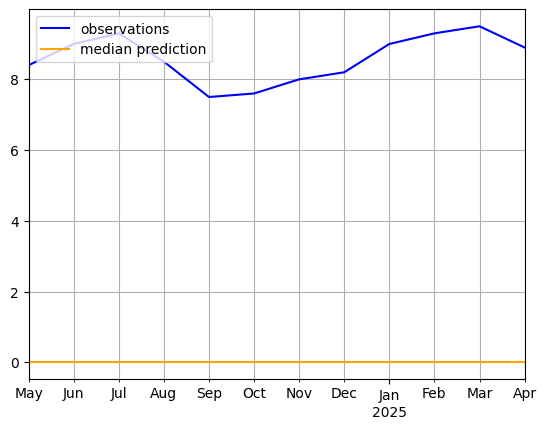

In [ ]:
def plot_prob_forecasts(truth, forecast):
    prediction_intervals = (0.5, 0.8)
    legend = ["observations", "median prediction"] + [f"{k*100}% prediction interval" for k in prediction_intervals][::-1]

    _, ax = plt.subplots(1, 1)
    truth.plot(ax=ax, color="blue", label="observations")

    # Extract the median prediction
    median = np.median(forecast, axis=0)
    ax.plot(truth.index, median, color="orange", label="median prediction")

    # Extract the prediction intervals if available
    if len(forecast) > 1:
        lower, upper = np.percentile(forecast, q=[(1 - k) * 100 / 2 for k in prediction_intervals], axis=0), np.percentile(
             forecast, q=[(1 + k) * 100 / 2 for k in prediction_intervals], axis=0)

    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

forecast_generator, truth_generator = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100,
)
truths = [truth for truth in truth_generator]
forecasts = [forecast for forecast in forecast_generator]

# Trying just one to start, can expand once the first makes sense
for i in range(1):
    truth = truths[i]
    forecast = np.array(forecasts[i].samples)
    plot_prob_forecasts(truth, forecast)

In [9]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(truths), iter(forecasts), num_series=len(test_data))
item_metrics

Running evaluation: 100%|██████████| 15/15 [00:00<00:00, 234.12it/s]


,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,num_masked_target_values,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2024-05,74.375000,103.200005,103.200005,8.600000,NaN,NaN,1.0,2.0,0.0,1.0,NaN,20.64,0.0,103.199999,0.0,185.759999,0.0
1,None,2024-05,17.861666,50.600002,50.600002,4.216667,NaN,NaN,1.0,2.0,0.0,1.0,NaN,10.12,0.0,50.600000,0.0,91.080000,0.0
2,None,2024-05,36.147499,71.500000,71.500000,5.958333,NaN,NaN,1.0,2.0,0.0,1.0,NaN,14.30,0.0,71.500000,0.0,128.699999,0.0
3,None,2024-05,19.176666,52.400002,52.400002,4.366667,NaN,NaN,1.0,2.0,0.0,1.0,NaN,10.48,0.0,52.400000,0.0,94.320000,0.0
4,None,2024-05,29.681666,65.200005,65.200005,5.433334,NaN,NaN,1.0,2.0,0.0,1.0,NaN,13.04,0.0,65.200000,0.0,117.360000,0.0
5,None,2024-05,22.272499,56.500004,56.500004,4.708334,NaN,NaN,1.0,2.0,0.0,1.0,NaN,11.30,0.0,56.500000,0.0,101.700000,0.0
6,None,2024-05,17.078334,49.399998,49.399998,4.116666,NaN,NaN,1.0,2.0,0.0,1.0,NaN,9.88,0.0,49.399999,0.0,88.919998,0.0
7,None,2024-05,63.259165,95.100006,95.100006,7.925001,NaN,NaN,1.0,2.0,0.0,1.0,NaN,19.02,0.0,95.100001,0.0,171.180002,0.0
8,None,2024-05,47.561666,82.600006,82.600006,6.883334,NaN,NaN,1.0,2.0,0.0,1.0,NaN,16.52,0.0,82.600000,0.0,148.680000,0.0
9,None,2024-05,17.435000,50.000000,50.000000,4.166667,NaN,NaN,1.0,2.0,0.0,1.0,NaN,10.00,0.0,50.000000,0.0,89.999999,0.0
